# Using LLMs as High-Level Planners for Multi-Agent Coordination

This notebook provides a step-by-step guide to customizing and interacting with the RL environment.

## For Submission
1. Fill in your code in `submit.py`. 
   - Add your code *only* in the TODO sections marked by the '#' delimiter lines. Do not modify any other parts of the script.
   - You should implement any helper functions/classes in a separate `helper.py` file and import them in `submit.py`.
1. Submit `out.log` and `results.csv` generated by the `submit.py` script.


In [1]:
# Import necessary libraries and modules
import gymnasium as gym
import multigrid.envs
import matplotlib.pyplot as plt
from agents import AgentCollection

%matplotlib inline
%load_ext autoreload
%autoreload 2

---
## Environment
- $N$ × $N$ square grid, where 50 ≤ $N$ ≤ 100.
  - The boundary cells are walls and hence the effective movement area will be ($N$ - 1) x ($N$ - 1).
- $M$ agents, where 2 ≤ $M$ ≤ 5, are placed at the same initial position at coordionate (1, 1).
- $T$ hidden targets are randomly placed in the grid.
- At the start of each episode, the environment provides a mission description, indicating regions (bounding box) where the targets are likely to be found.
  - e.g., “The region from (0, 0) to (5, 5) contains 5 targets. The region from (5, 5) to (10, 10) contains 5 targets.”

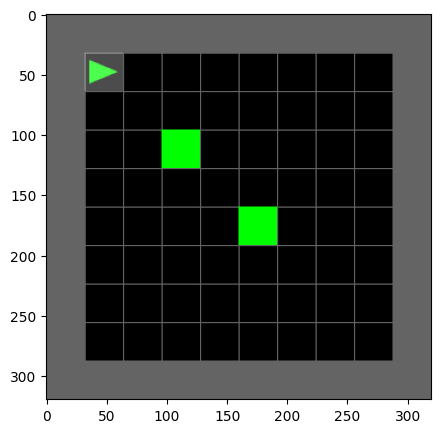

In [8]:
# # Use a predefined environment
# env = gym.make('MultiGrid-EmptyEnvV2-hidden-20x20-v0', agents=2, render_mode='rgb_array')

# Customize the environment
env = multigrid.envs.EmptyEnvV2(
    size=10,  # Specify the size of the grid, N
    agents=2,  # Specify number of agents, M
    goals=[(3, 3), (5, 5)],  # Specify target positions for agents
    mission_space="All targets are contained within the region from (3, 3) to (5, 5).",
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

# Render the environment
img = env.render()
plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.show()

---
## Initial Plan Generation

An intial plan can be generated by the `initial_planner` by invoking it with the grid size and number of agents available.

In [9]:
from planner import initial_planner
from tracker import Tracker

agents={0: [MoveAction(type=<ActionType.MOVE: 'move'>, cur_x=1, cur_y=1, tar_x=3, tar_y=3), SearchAction(type=<ActionType.SEARCH: 'search'>, cur_x=3, cur_y=3, x1=1, y1=1, x2=5, y2=5), MoveAction(type=<ActionType.MOVE: 'move'>, cur_x=3, cur_y=3, tar_x=8, tar_y=3), SearchAction(type=<ActionType.SEARCH: 'search'>, cur_x=8, cur_y=3, x1=6, y1=1, x2=10, y2=5)], 1: [MoveAction(type=<ActionType.MOVE: 'move'>, cur_x=1, cur_y=1, tar_x=3, tar_y=8), SearchAction(type=<ActionType.SEARCH: 'search'>, cur_x=3, cur_y=8, x1=1, y1=6, x2=5, y2=10), MoveAction(type=<ActionType.MOVE: 'move'>, cur_x=3, cur_y=8, tar_x=8, tar_y=8), SearchAction(type=<ActionType.SEARCH: 'search'>, cur_x=8, cur_y=8, x1=6, y1=6, x2=10, y2=10)]}
{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are 

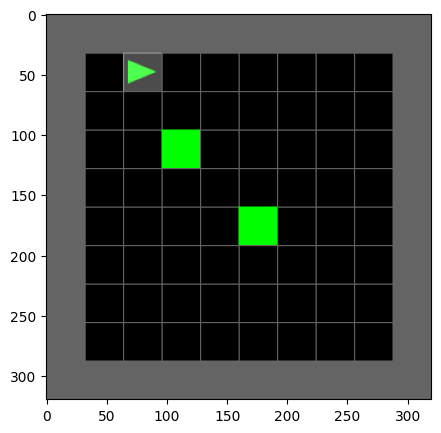

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(1))}, 'global': {'num_goals': 2}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


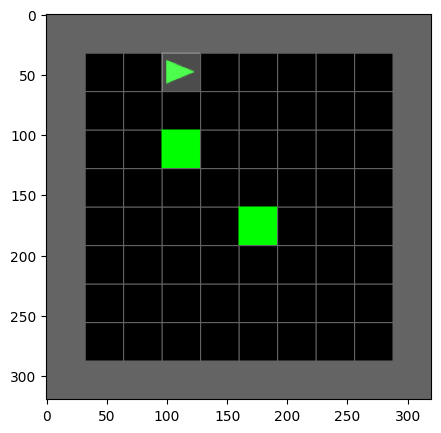

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(2))}, 'global': {'num_goals': 2}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


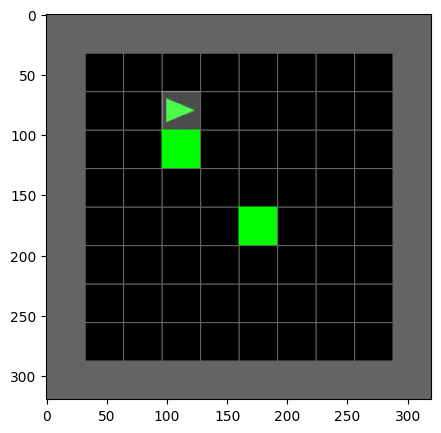

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(3))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: 1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


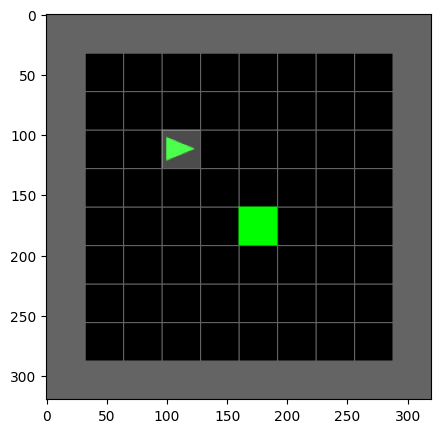

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(4))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


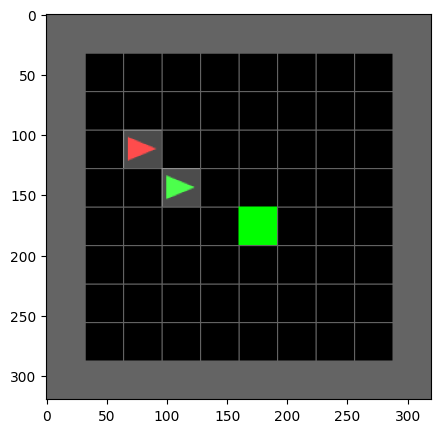

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(5))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


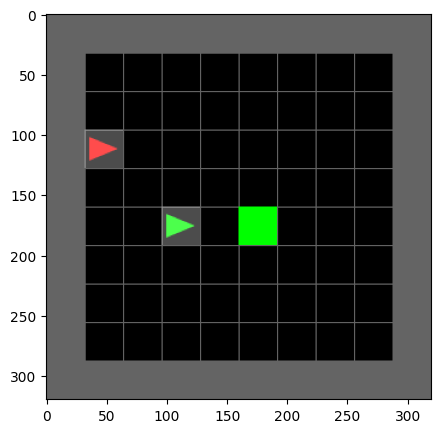

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


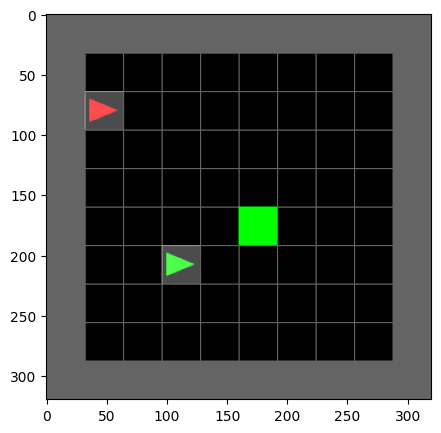

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.up: 2>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


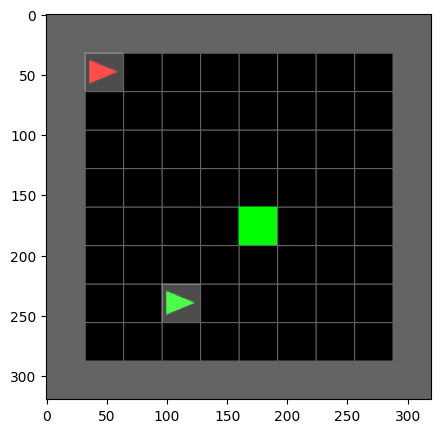

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


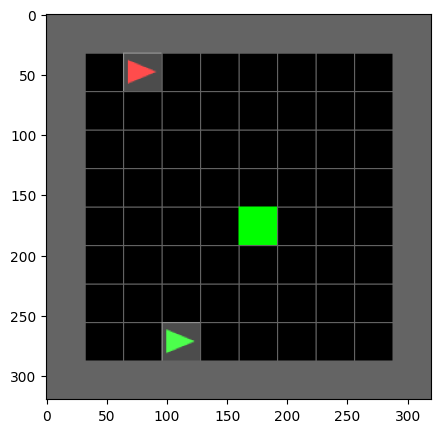

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


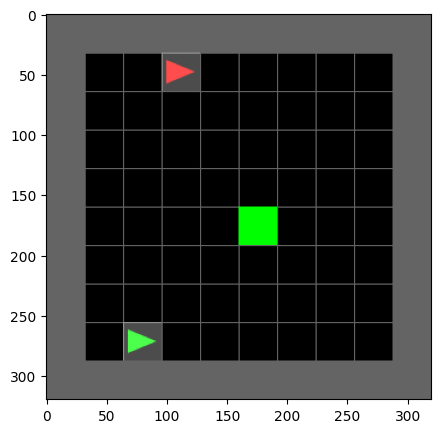

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


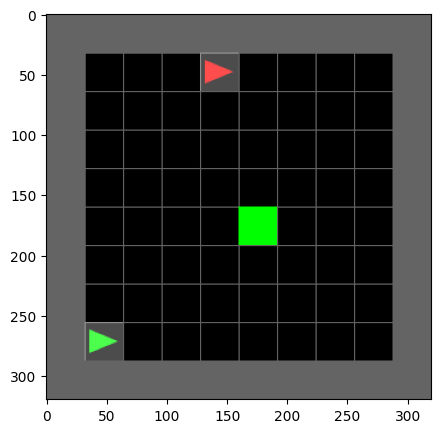

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(1))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.up: 2>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


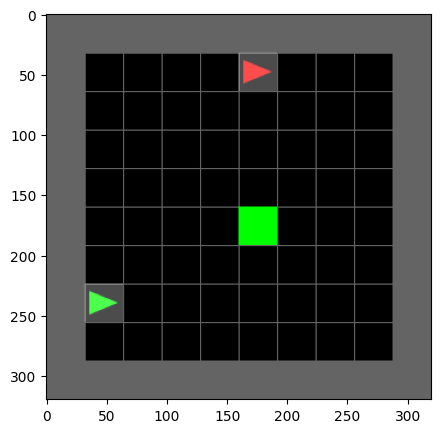

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.up: 2>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


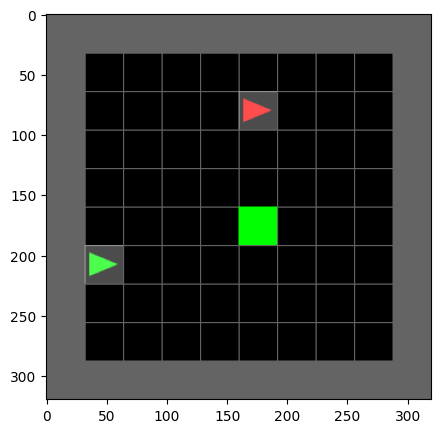

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


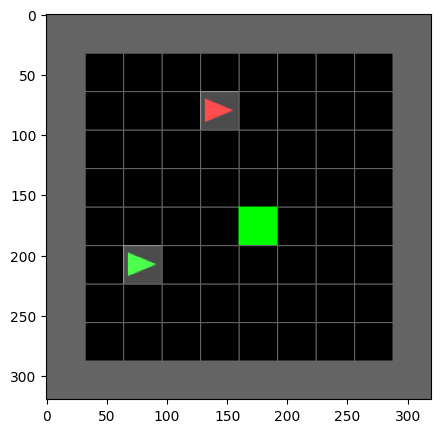

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


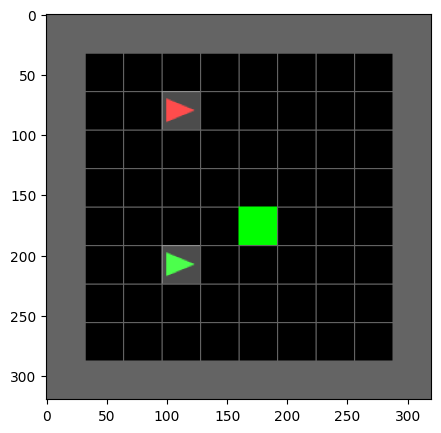

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


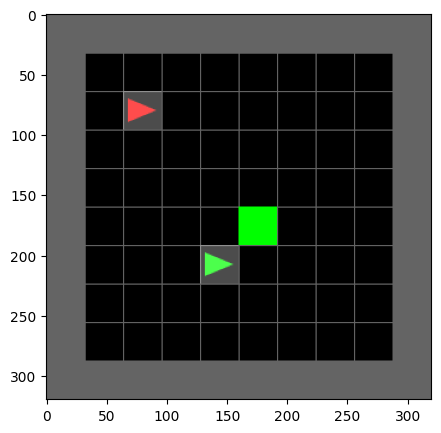

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(2))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(6))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


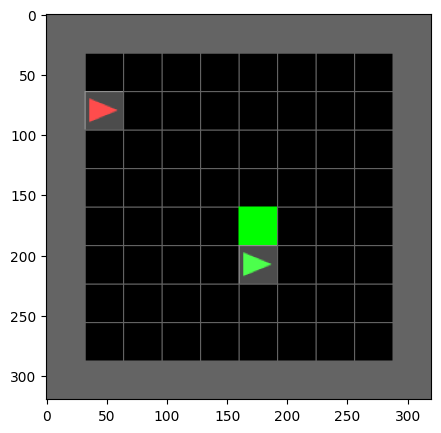

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


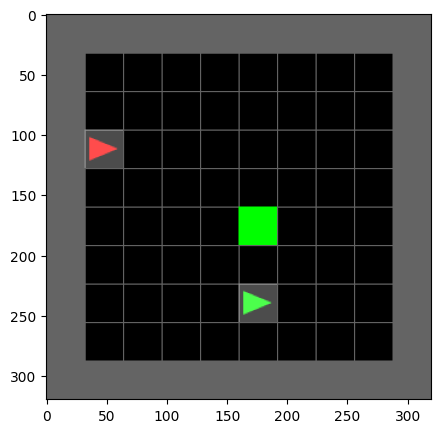

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


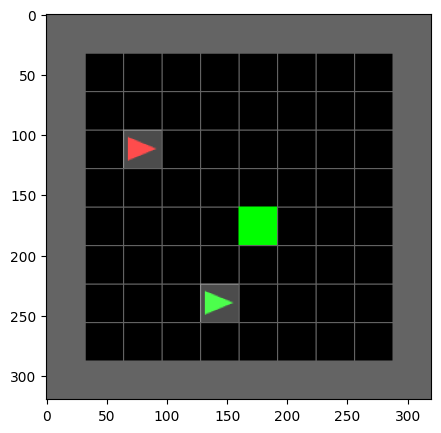

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


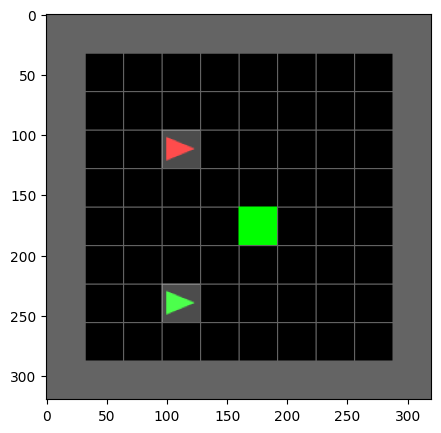

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


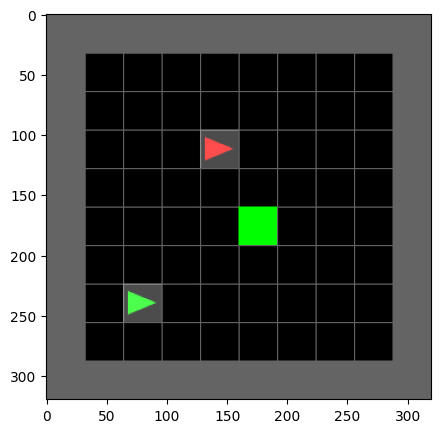

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(3))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(7))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


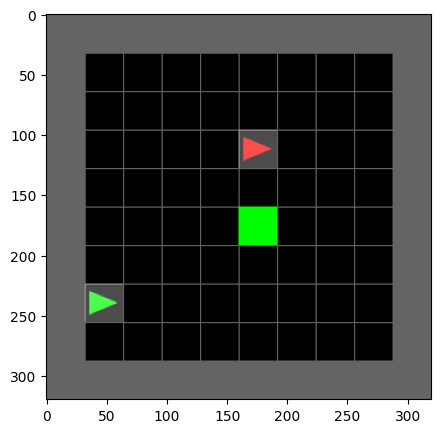

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(4))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


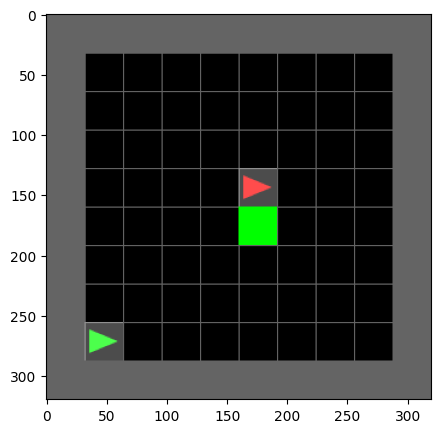

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(4))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


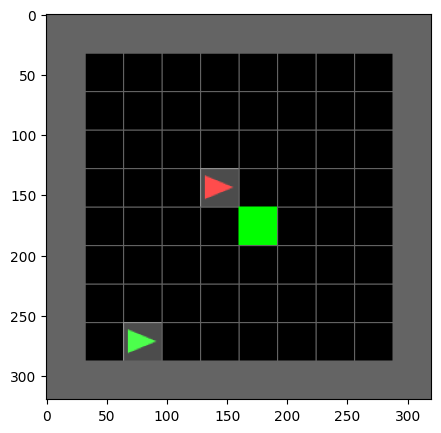

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(4))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


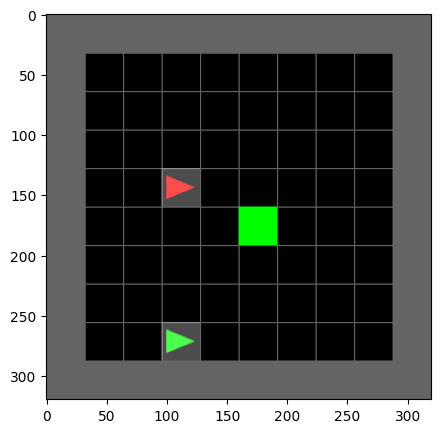

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(4))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


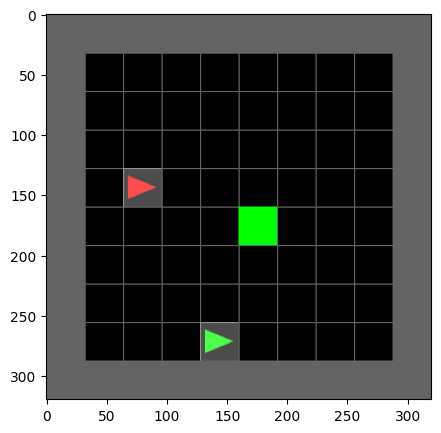

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(4))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


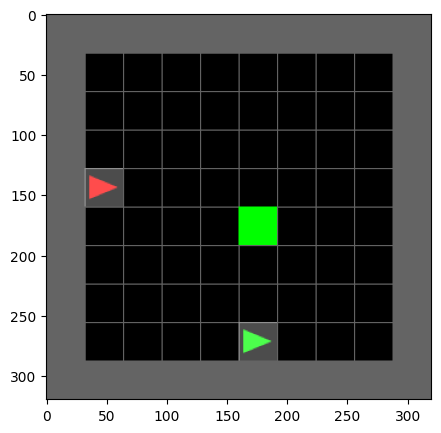

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(1), np.int64(5))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


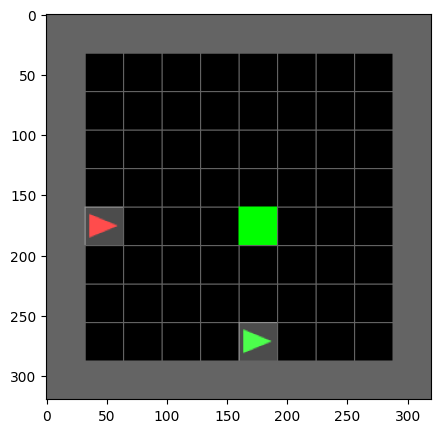

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(5))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


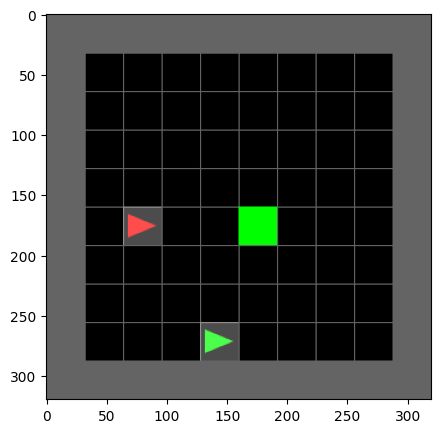

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(5))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(3), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


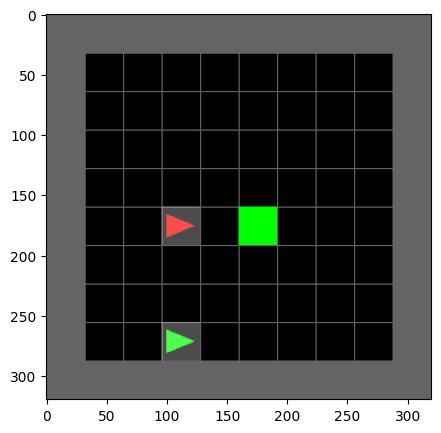

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(4), np.int64(5))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(8))}, 'global': {'num_goals': 1}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


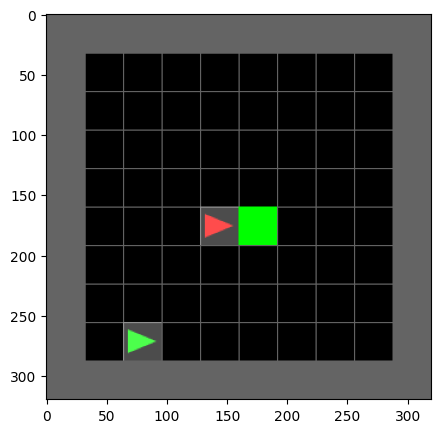

{0: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(5), np.int64(5))}, 1: {'image': array([[[1, 0, 0]]]), 'direction': np.int64(0), 'mission': Mission("All targets are contained within the region from (3, 3) to (5, 5)."), 'location': (np.int64(2), np.int64(8))}, 'global': {'num_goals': 0}}
{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: 1, 1: -1} {0: np.True_, 1: np.True_} {0: False, 1: False}
[[1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 2. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 2. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


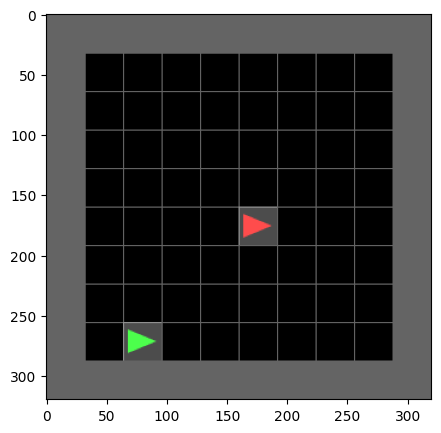

In [26]:
N, M = 10, 2
env = multigrid.envs.EmptyEnvV2(
    size=N,  # Specify the size of the grid, N
    agents=M,  # Specify number of agents, M
    goals=[(3, 3), (5, 5)],  # Specify target positions for agents
    mission_space="All targets are contained within the region from (3, 3) to (5, 5).",
    render_mode="rgb_array",
    hidden_goals=True,
    # max_steps=50, # For debugging, you can set a maximum number of steps
)

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions
mission = observations[0]["mission"]
plan = initial_planner.invoke({"grid_length": N, "num_agents": M, "mission": mission})
print(plan)
tracker = Tracker(N)
for agent, actions in plan.agents.items():
    for action in actions:
        agents.tell({agent: action.serialize()})

while not agents.all_idle() and not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(observations)
    print(a, rewards, terminations, truncations)
    tracker.observe(observations, rewards)
    print(tracker.grid.T)
    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

env.close()

---
## Advance Usage
We can chain high-level actions (Example 1) and also dynamically replans (Example 2 and Example 3).

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


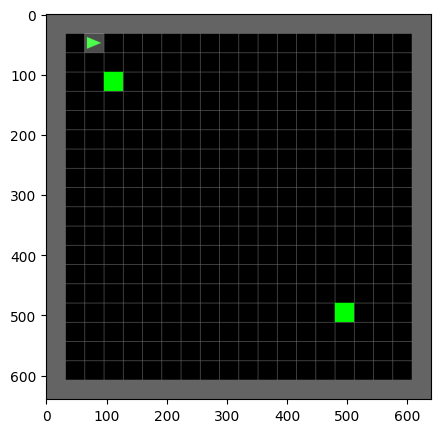

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


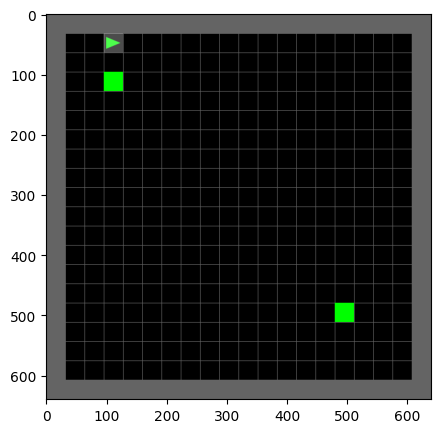

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


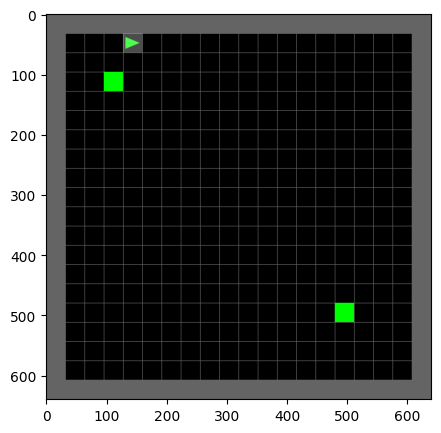

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


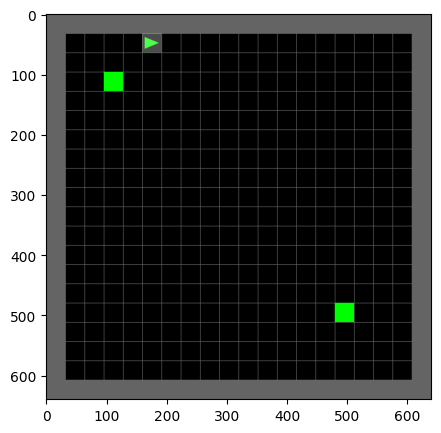

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


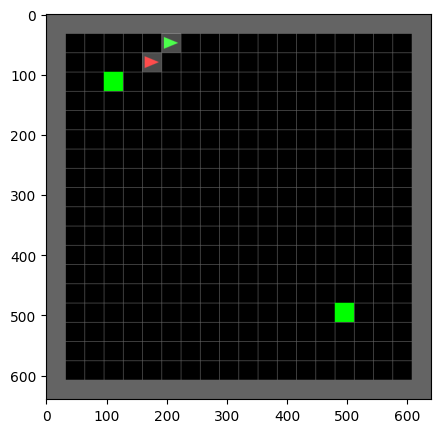

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


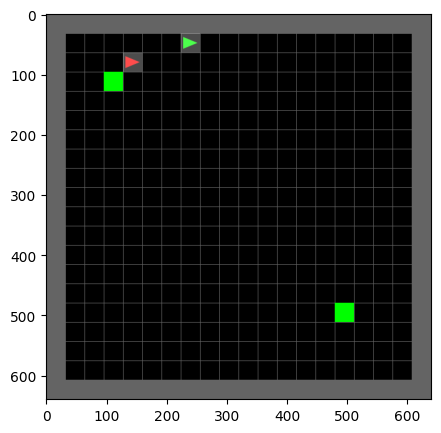

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


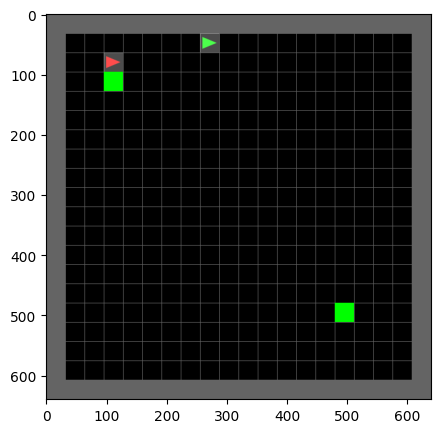

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


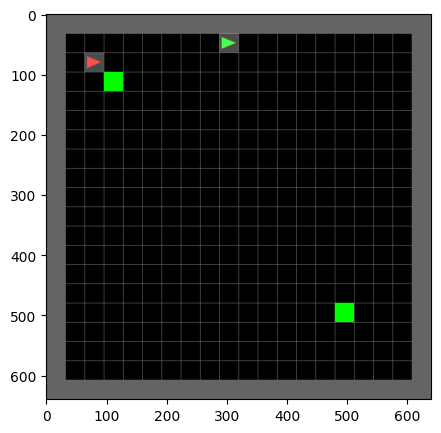

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


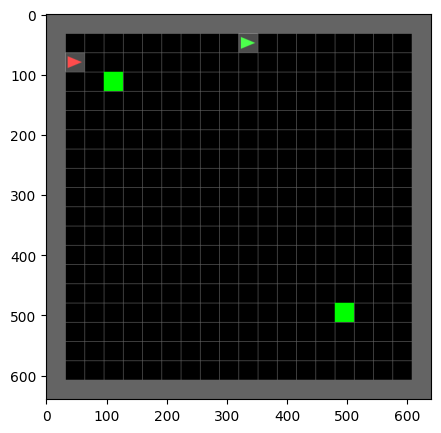

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


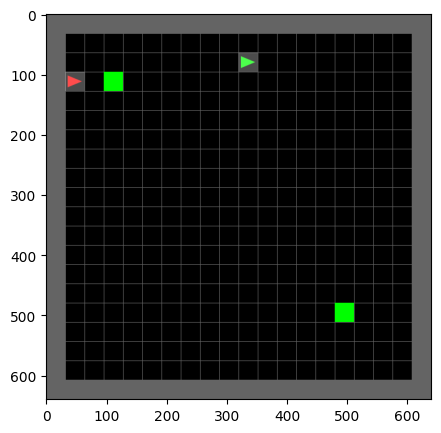

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


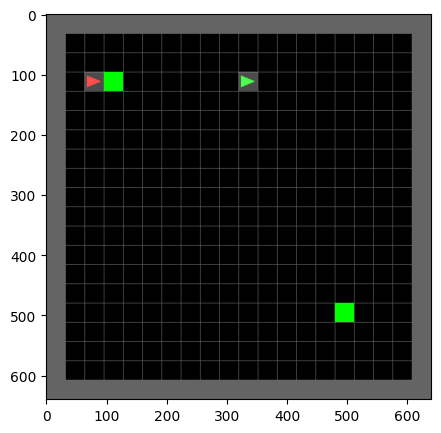

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: 1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


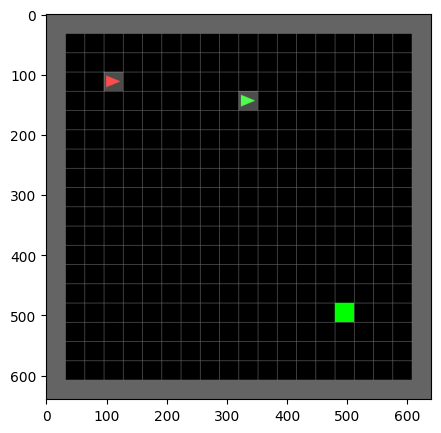

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


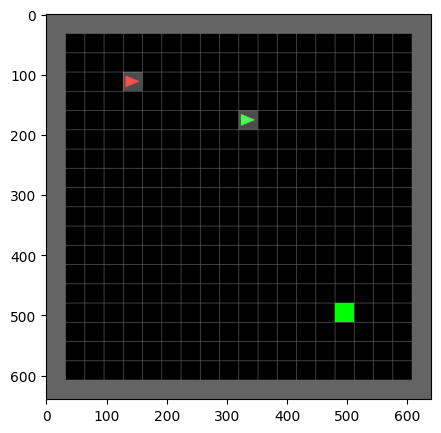

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


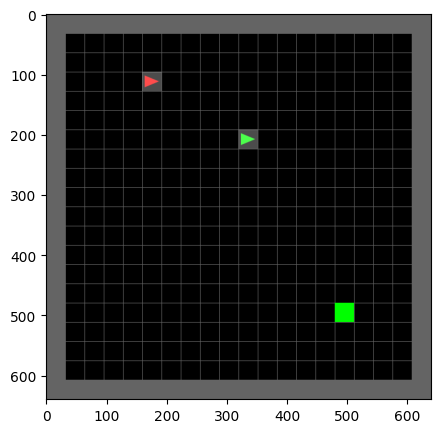

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


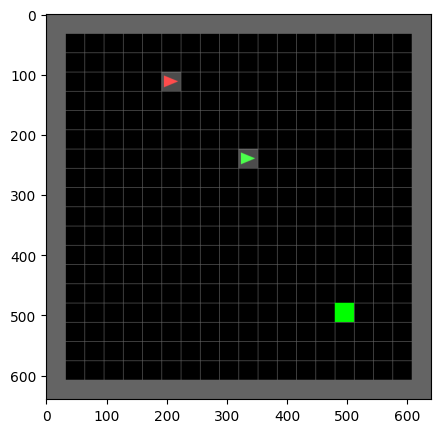

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


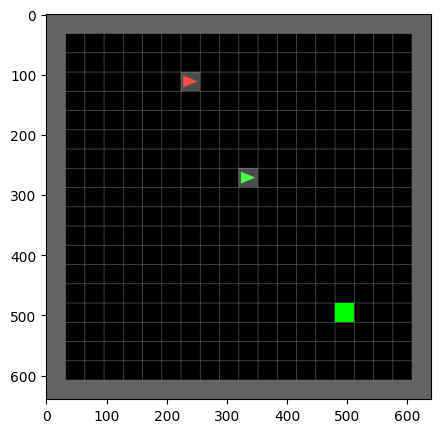

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


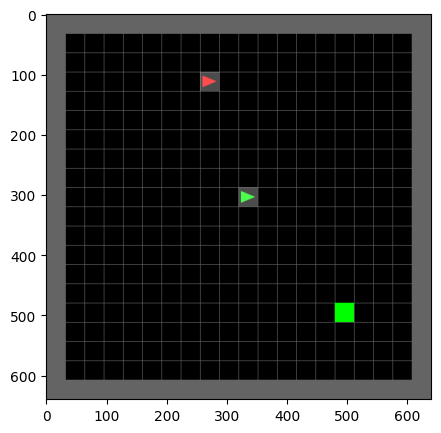

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


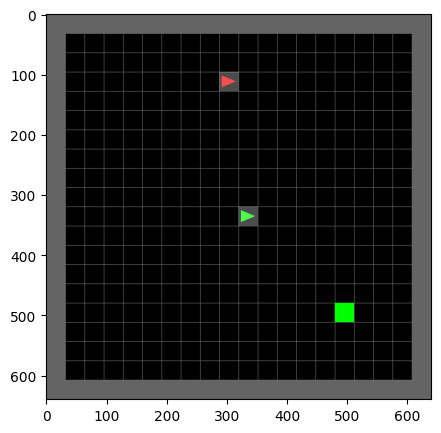

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


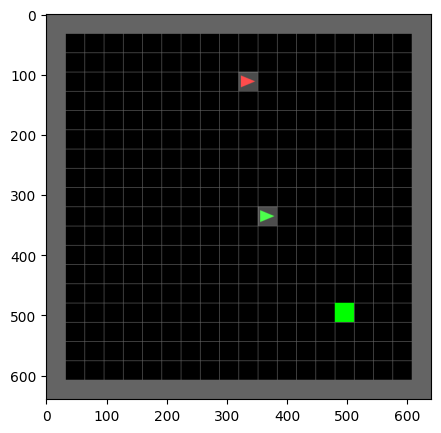

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


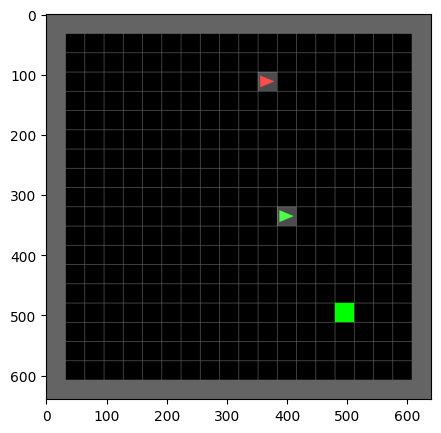

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


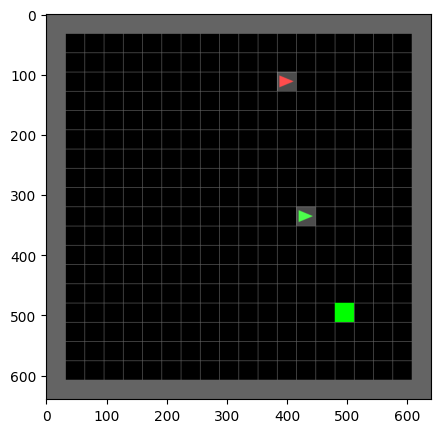

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


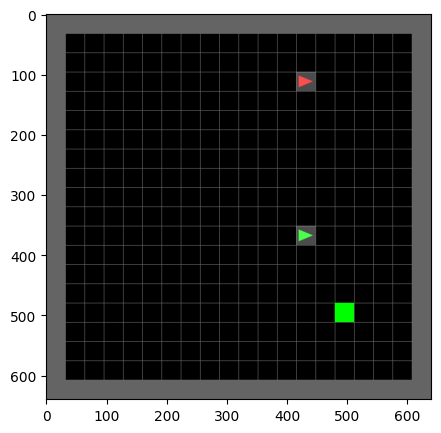

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


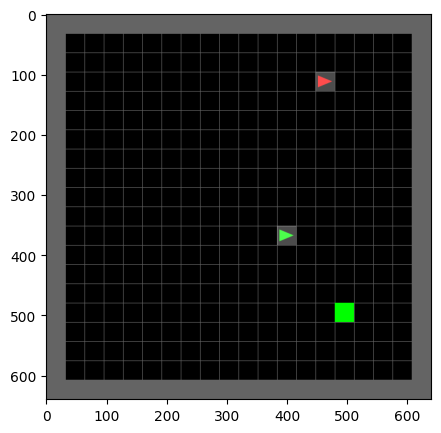

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


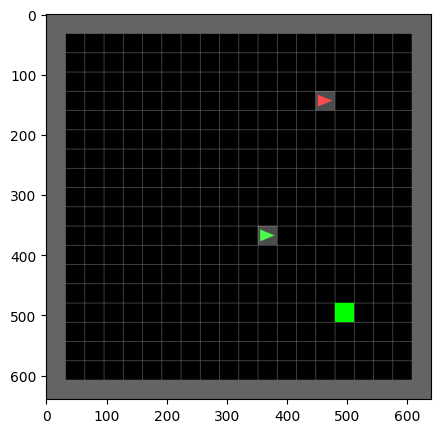

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


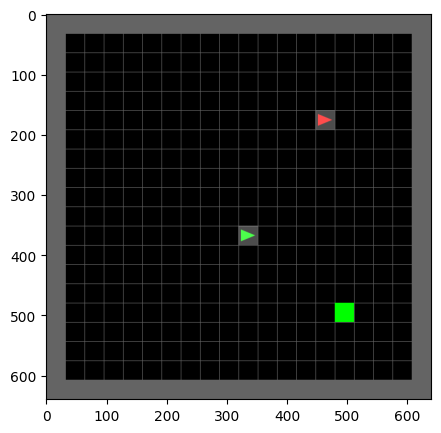

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


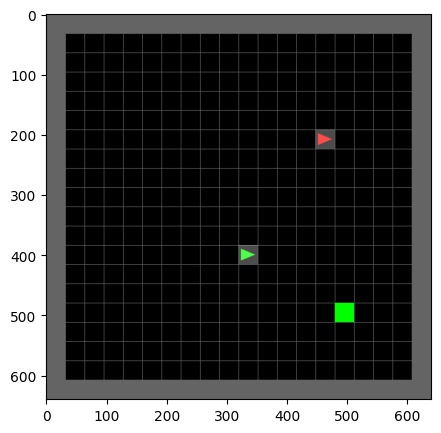

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


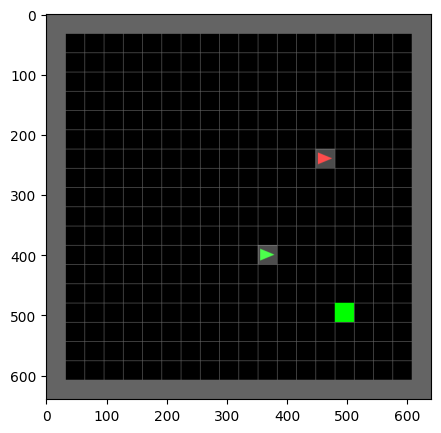

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


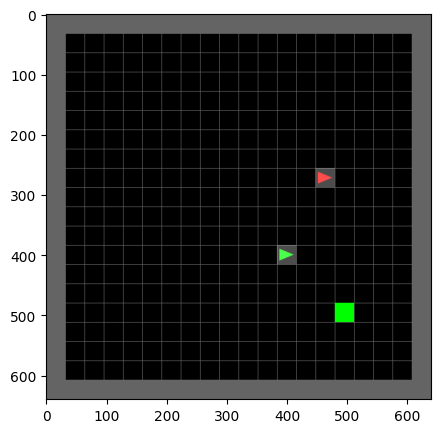

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


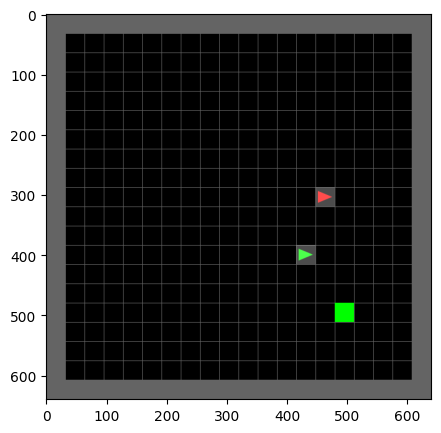

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


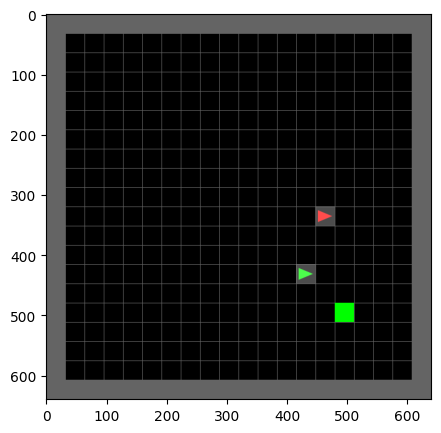

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


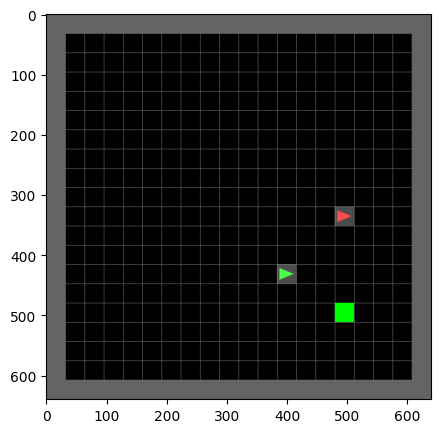

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


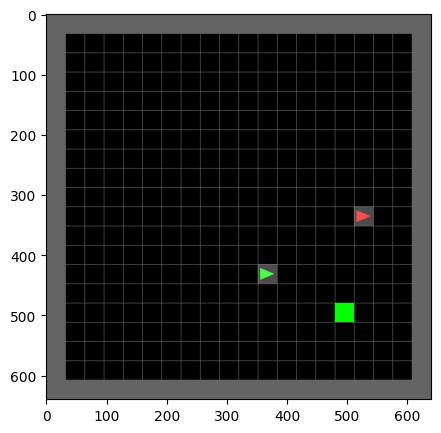

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


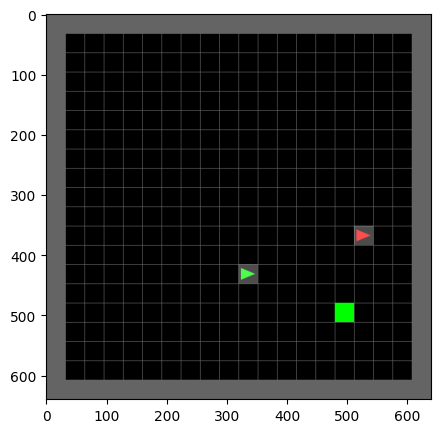

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


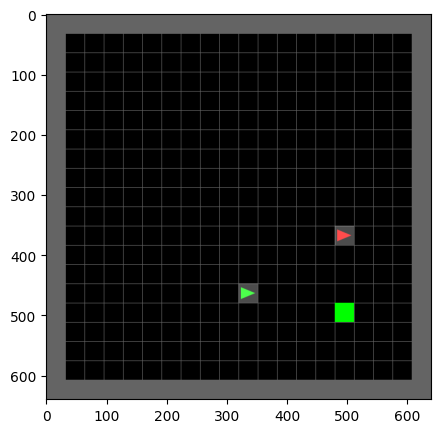

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


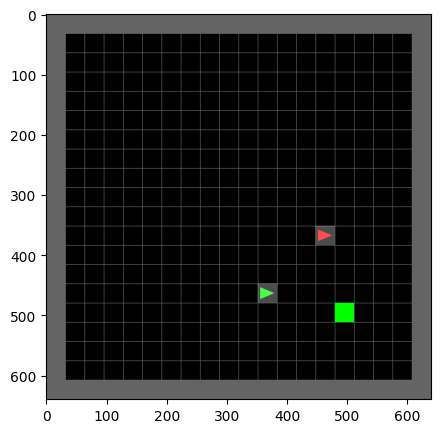

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


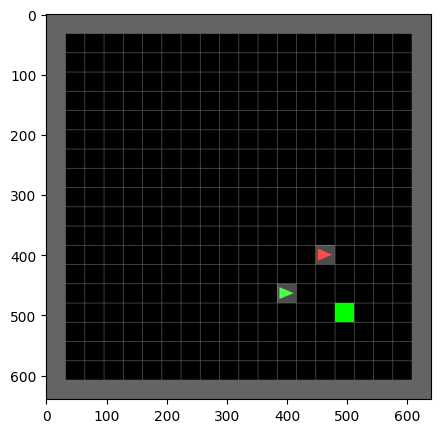

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.right: 1>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


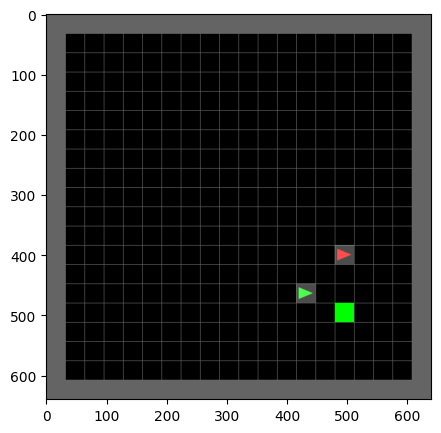

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.down: 3>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


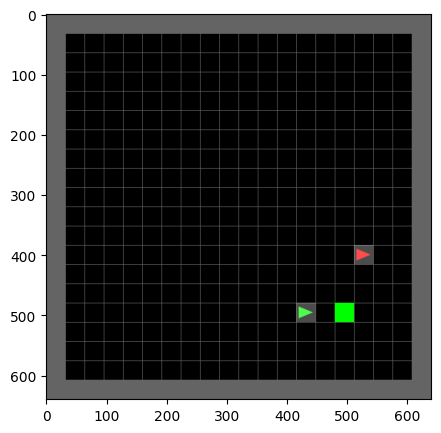

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


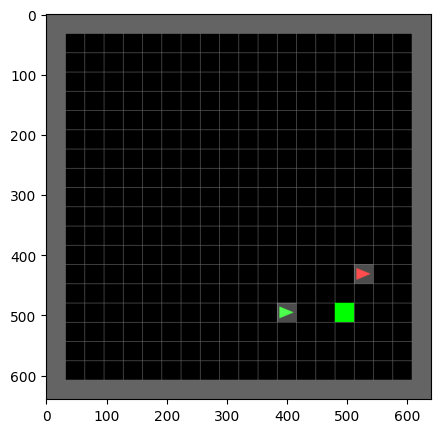

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


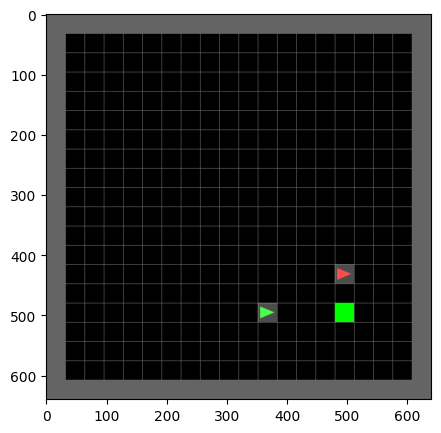

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.left: 0>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


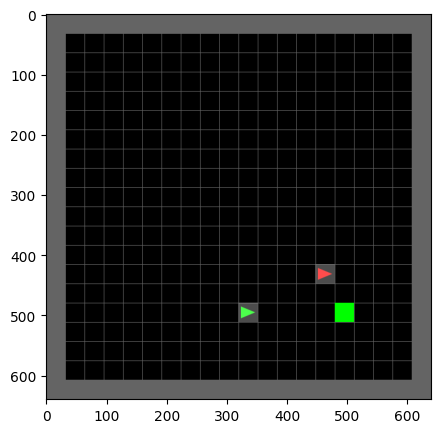

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


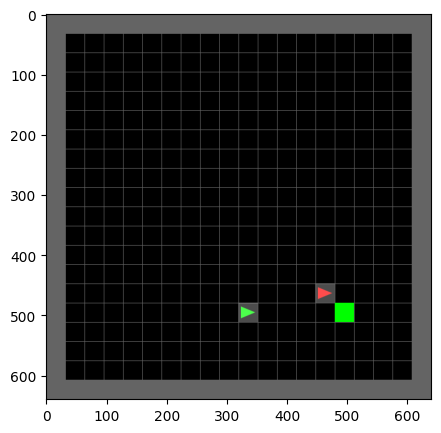

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


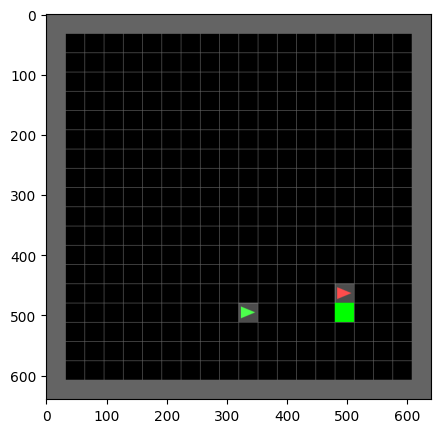

{0: <ActionUpDown.right: 1>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


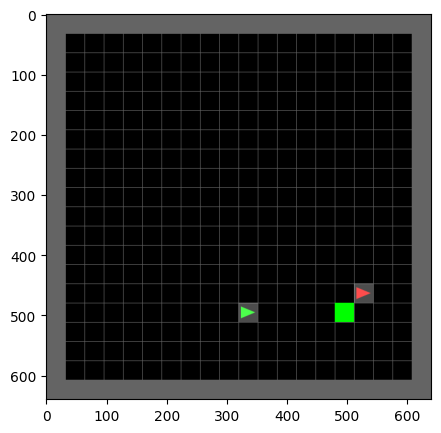

{0: <ActionUpDown.down: 3>, 1: <ActionUpDown.done: 7>} {0: -1, 1: -1} {0: np.False_, 1: np.False_} {0: False, 1: False}


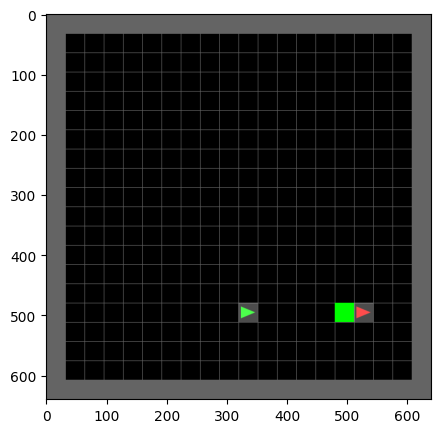

{0: <ActionUpDown.left: 0>, 1: <ActionUpDown.done: 7>} {0: 1, 1: -1} {0: np.True_, 1: np.True_} {0: False, 1: False}


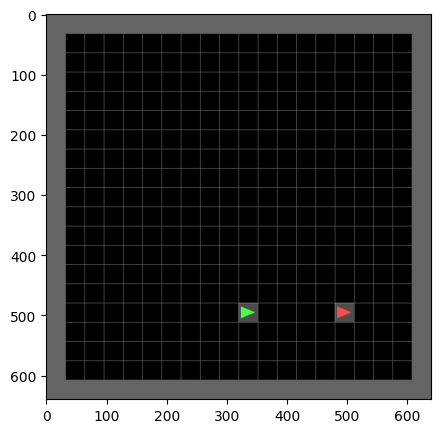

In [ ]:
env = multigrid.envs.EmptyEnvV2(
    size=20,  # Specify the size of the grid, N
    agents=2,  # Specify number of agents, M
    goals=[(3, 3), (15, 15)],  # Specify target positions for agents
    mission_space="One target is contained within the region from (1, 1) to (5, 5) and the other target is contained within the region from (10, 10) to (16, 16).",
    render_mode="rgb_array",
    hidden_goals=True,
)

# Always reset the environment before starting
observations, infos = env.reset()

# Create a group of 2 agents
agents = AgentCollection(num=2)

# Providing the agents with high-level instructions.
# Again, these instructions should be generated by your LLM and not hardcoded.
agents.tell(
    {
        0: "search(1, 1, 1, 1, 5, 5)",
        1: "move(1, 1, 10, 10)",
    }
)

# Example 1: Chaining high-level actions for Agent 1
agents.tell(
    {
        1: "search(10, 10, 10, 10, 13, 15)",
    }
)
while not env.unwrapped.is_done():
    # Obtain the low-level action for current time step for all agents
    a = agents.act()

    # Step the environment with the actions
    observations, rewards, terminations, truncations, infos = env.step(a)
    print(a, rewards, terminations, truncations)

    # Render the environment
    img = env.render()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.show()

    # Example 2: Replan after finding a target.
    for i in agents.agents:
        if rewards[i] > 0:  # Agent i has found a target
            # Stop Agent i if it has found a target
            agents.tell({i: "stop()"})
            # Replan Agent i to search for the second target
            cur_x, cur_y = observations[i]["location"]
            agents.tell({i: f"search({cur_x}, {cur_y}, 14, 10, 16, 16)"})

    # Example 3: Replan when all agents are idle
    if agents.all_idle():
        print("All agents are idle.")
        # Consider to do something here, e.g., replan with LLM
        break
env.close()

---
# Resources

[Introduction to RL - OpenAI](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html)